In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
from analysis import plot as analysis_plot
import scipy as sp
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.base import clone
import seaborn as sns
import pickle
from scipy.stats import multivariate_normal

%matplotlib inline

In [39]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

In [74]:
def gaussian_entropy(cov):
    # https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/
    assert cov.shape == (64,64)
    # (D/2)*(1 + log(2pi)) + (1/2)*log(det(C))
    return 32*(1 + np.log(2*np.pi)) + 0.5*np.log(np.linalg.det(cov))

def total_gmm_entropy(model):
    assert len(model.covariances_) > 0
    return np.sum([gaussian_entropy(c)*w for c, w in zip(model.covariances_,model.weights_)])

In [77]:
with open('subject_models.pkl', 'rb') as handle:
    subject_models = pickle.load(handle)

with open('subject_prior_models.pkl', 'rb') as handle:
    subject_prior_models = pickle.load(handle)

In [78]:
model_entropies = []
prior_entropies = []
for subject_idx in range(len(subjects)):
    model_entropies.append([total_gmm_entropy(models) for models in subject_models[subject_idx]])
    prior_entropies.append(total_gmm_entropy(subject_prior_models[subject_idx]))

In [79]:
len(model_entropies[0]), len(prior_entropies), len(subjects)

(5, 46, 46)

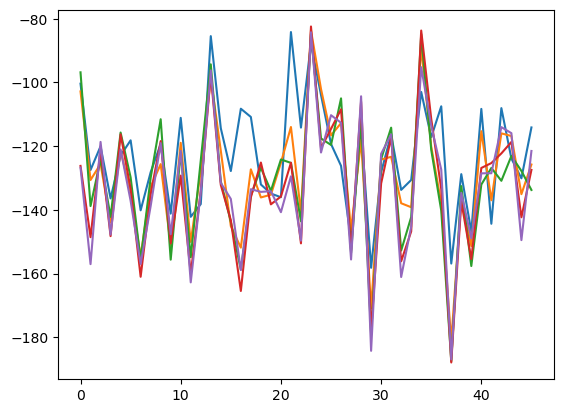

In [80]:
plt.plot(model_entropies)

### higher performers tend to decrease the entropy of their responses, honing in on a strategy

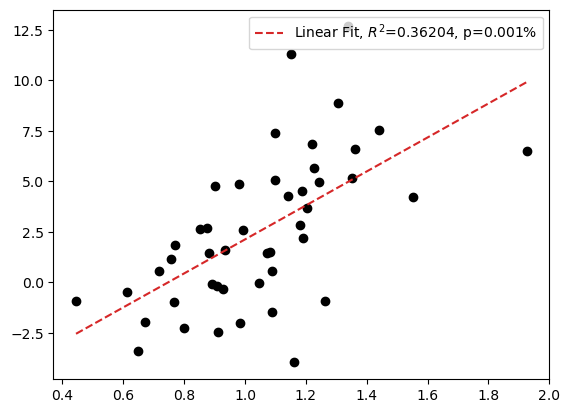

In [118]:
mean_entropy_diffs = [np.mean(np.array(models)[:-1]-np.array(models)[1:]) for models in model_entropies]
stop_subjects = []
mr = [m for i,m in enumerate(mean_rewards) if not i in stop_subjects]
med = [m for i,m in enumerate(mean_entropy_diffs) if not i in stop_subjects]
plt.plot(mr,med,"ko")
for i in stop_subjects:
    plt.plot(mean_rewards[i],mean_entropy_diffs[i],"ro")
r = linear_fit(mr, med)
x = linspace(mr)
plot_linear_fit(x,r,plt.gca())
plt.legend()

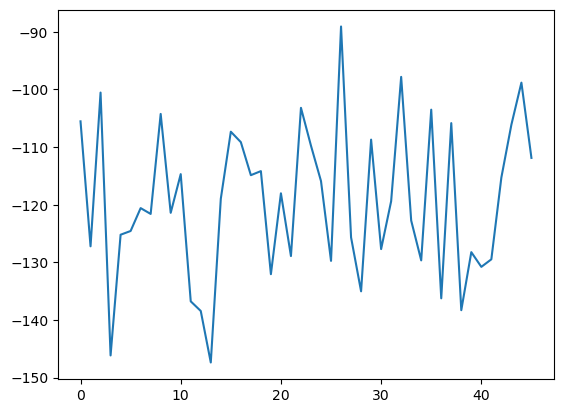

In [81]:
plt.plot(prior_entropies)

## prior entropies are not predictive of model entropies!

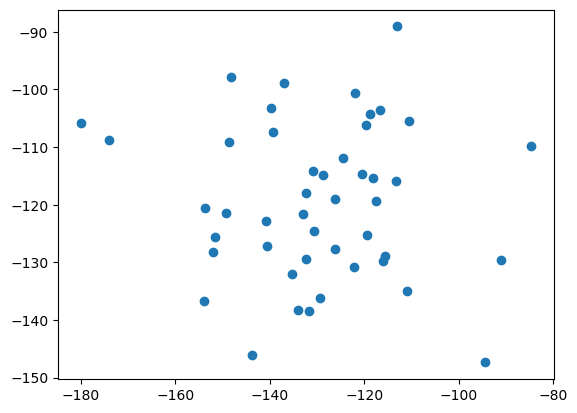

In [98]:
plt.plot([np.mean(ms) for ms in model_entropies],prior_entropies, "o")

In [83]:
reward_df = pd.read_pickle("trajectory_dataframe.pkl")
mean_rewards = reward_df.groupby(level=["subject"]).mean()["reward"]**-1
mean_rewards.shape

(46,)

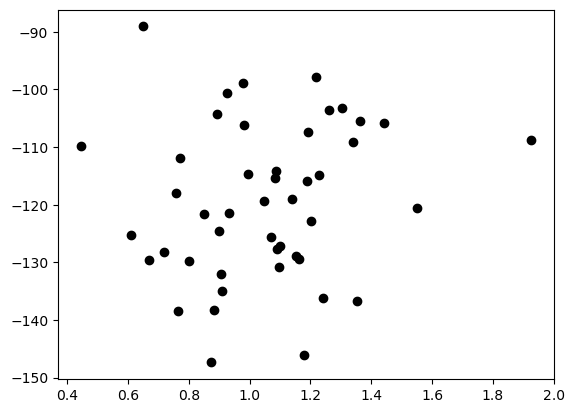

In [84]:
plt.plot(mean_rewards, prior_entropies,"ko")

In [88]:
def linear_fit(x_data, y_data):
    result = sp.stats.linregress(x_data, y_data)
    return result

def plot_linear_fit(x, result, ax):
    ax.plot(x, result.intercept + result.slope*x,"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}, p={np.round(result.pvalue*100,3)}%")

def linspace(data):
    return np.linspace(np.min(data),np.max(data),100,endpoint=True)

(array([ 7.,  1., 12., 27., 35., 57., 51., 20., 10., 10.]),
 array([-187.93526563, -177.38417974, -166.83309385, -156.28200797,
        -145.73092208, -135.17983619, -124.6287503 , -114.07766442,
        -103.52657853,  -92.97549264,  -82.42440675]),
 <BarContainer object of 10 artists>)

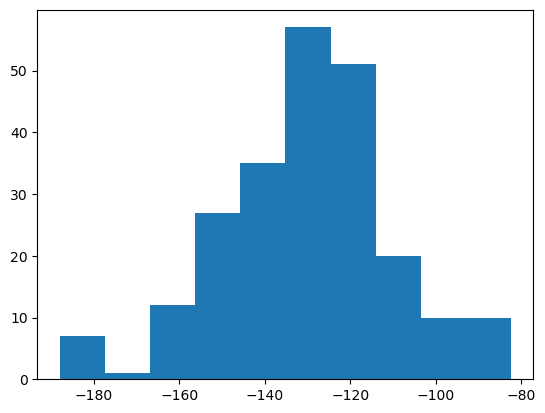

In [89]:
plt.hist(np.array(model_entropies).flatten())

### higher entropy -- more equiprobable outcomes || lower entropy -- less equiprobable outcomes

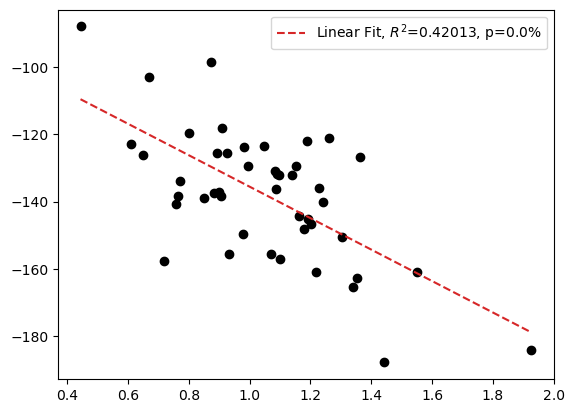

In [97]:
plt.plot(mean_rewards, [np.min(ms) for ms in model_entropies],"ko")
r = linear_fit(mean_rewards, [np.min(ms) for ms in model_entropies])
x = linspace(mean_rewards)
plot_linear_fit(x,r,plt.gca())
plt.legend()

### lower min entropy predictive of performance... perhaps due to stereotyped behavior